In [ ]:
from google.colab import drive
import platform
import os
import cv2
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, accuracy_score
import seaborn as sns
import tensorflow as tf

print(tf.__version__)
import keras
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.models import load_model
from keras.applications import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions

from keras.preprocessing import image
import numpy as np
from sklearn.utils import class_weight
from google.colab import files
import tempfile
import shutil

from tensorflow.python.keras.regularizers import l1
from tensorflow.python.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd
# drive.mount('/content/drive')
from tensorflow.python.keras.callbacks import Callback
import time

print(platform.python_version())

2.17.0
2.17.0
3.10.12


# **Przygotowanie danych**

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1lucBLdPkqiNFLLTBD8CfBAbDWDbIRpdr/view?usp=sharing

In [ ]:
!unzip /content/zapisane/breast-20240528T194810Z-001.zip -d /content/zapisane/breast1

In [ ]:
!find /content/zapisane/breast/breastAfterDivision/train/benign  -type f | wc -l
!find /content/zapisane/breast/breastAfterDivision/AfterAug/benign -type f | wc -l

In [ ]:
#@title wyswietlenie ilosci danych dla poszczególnych klas
data_dir = '/content/zapisane/breast/breast'
raw_number_of_files = {}
classes = ['benign','malignant']
for dir in classes:
    raw_number_of_files[dir] = len(os.listdir(os.path.join(data_dir, dir)))

raw_number_of_files.items()

In [ ]:
#@title Wyswietlenie przykladowego zdjecia ze zbioru
impath="/content/zapisane/breast/breast/benign/SOB_B_A-14-22549AB-100-012.png"

img = image.load_img(impath)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

from PIL import Image
img = Image.open(impath)

width,height = img.size

print("The height of the image is: ", height)
print("The width of the image is: ", width)

In [ ]:
#@title Podział zbioru danych na testowy, treningowy, walidacyjny

base_dir = '/content/zapisane/breast/breast'

CLS_1 = 'benign'
CLS_2 = 'malignant'
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
DATA_DIR = '/content/zapisane/breast/breastAfterDivision'

classes = [CLS_1, CLS_2]

number_of_samples = [(dir, len(os.listdir(os.path.join(base_dir, dir)))) for dir in classes]
print(number_of_samples)

if not os.path.exists(DATA_DIR): os.makedirs(DATA_DIR, exist_ok=True)

#tworzenie ścieżek do folderów train, valid i test
train_dir = os.path.join(DATA_DIR, 'train')
valid_dir = os.path.join(DATA_DIR, 'valid')
test_dir = os.path.join(DATA_DIR, 'test')

#tworzenie sciezek do podfolderów poszczególnych klas
train_cls_1_dir = os.path.join(train_dir, CLS_1)
valid_cls_1_dir = os.path.join(valid_dir, CLS_1)
test_cls_1_dir = os.path.join(test_dir, CLS_1)
train_cls_2_dir = os.path.join(train_dir, CLS_2)
valid_cls_2_dir = os.path.join(valid_dir, CLS_2)
test_cls_2_dir = os.path.join(test_dir, CLS_2)

#tworzenie odpowiednich folderów:
for dir in (train_dir, valid_dir, test_dir):
    if not os.path.exists(dir):
        os.makedirs(dir, exist_ok=True)

for dir in (train_cls_1_dir, valid_cls_1_dir, test_cls_1_dir):
    if not os.path.exists(dir):
        os.makedirs(dir, exist_ok=True)

for dir in (train_cls_2_dir, valid_cls_2_dir, test_cls_2_dir):
    if not os.path.exists(dir):
        os.makedirs(dir, exist_ok=True)

print('[INFO] Wczytanie nazw plików...')
cls_1_names = os.listdir(os.path.join(base_dir, CLS_1))
cls_2_names = os.listdir(os.path.join(base_dir, CLS_2))

print('[INFO] Walidacja poprawności rozszerzenia plików...')
cls_1_names = [fname for fname in cls_1_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
cls_2_names = [fname for fname in cls_2_names if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]


print(f'[INFO] Liczba obrazów w zbiorze {CLS_1}: {len(cls_1_names)}')
print(f'[INFO] Liczba obrazów w zbiorze {CLS_2}: {len(cls_2_names)}')

train_idx_cls_1 = int(TRAIN_RATIO * len(cls_1_names))
valid_idx_cls_1 = train_idx_cls_1 + int(VALID_RATIO * len(cls_1_names))

train_idx_cls_2 = int(TRAIN_RATIO * len(cls_2_names))
valid_idx_cls_2 = train_idx_cls_2 + int(VALID_RATIO * len(cls_2_names))

# Zaokrąglenie w dół do najbliższej liczby podzielnej przez 10
train_idx_cls_2 = (train_idx_cls_2 // 10) * 10
valid_idx_cls_2 = (valid_idx_cls_2 // 10) * 10

print('[INFO] Kopiowanie plików do katalogów docelowych...')
for i, fname in enumerate(cls_1_names):
    if i <= train_idx_cls_1:
        src = os.path.join(base_dir, CLS_1, fname)
        dst = os.path.join(train_cls_1_dir, fname)
        shutil.copyfile(src, dst)
    if train_idx_cls_1 < i <= valid_idx_cls_1:
        src = os.path.join(base_dir, CLS_1, fname)
        dst = os.path.join(valid_cls_1_dir, fname)
        shutil.copyfile(src, dst)
    if valid_idx_cls_1 < i <= len(cls_1_names):
        src = os.path.join(base_dir, CLS_1, fname)
        dst = os.path.join(test_cls_1_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(cls_2_names):
    if i <= train_idx_cls_2:
        src = os.path.join(base_dir, CLS_2, fname)
        dst = os.path.join(train_cls_2_dir, fname)
        shutil.copyfile(src, dst)
    if train_idx_cls_2 < i <= valid_idx_cls_2:
        src = os.path.join(base_dir, CLS_2, fname)
        dst = os.path.join(valid_cls_2_dir, fname)
        shutil.copyfile(src, dst)
    if valid_idx_cls_2 < i <= len(cls_2_names):
        src = os.path.join(base_dir, CLS_2, fname)
        dst = os.path.join(test_cls_2_dir, fname)
        shutil.copyfile(src, dst)

print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze treningowym: {len(os.listdir(train_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze validacyjnym: {len(os.listdir(valid_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_1} w zbiorze testowym: {len(os.listdir(test_cls_1_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze treningowym: {len(os.listdir(train_cls_2_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze validacyjnym: {len(os.listdir(valid_cls_2_dir))}')
print(f'[INFO] Liczba obrazów klasy {CLS_2} w zbiorze testowym: {len(os.listdir(test_cls_2_dir))}')

In [ ]:
#@title Sprawdzanie ilości danych w poszczególnych zbiorach
!ls -l //content/zapisane/breastAfterDivision2/train/benign | wc -l
!ls -l //content/zapisane/breastAfterDivision2/valid/benign | wc -l
!ls -l //content/zapisane/breastAfterDivision2/test/benign | wc -l

!ls -l //content/zapisane/breastAfterDivision2/train/malignant | wc -l
!ls -l //content/zapisane/breastAfterDivision2/valid/malignant | wc -l
!ls -l //content/zapisane/breastAfterDivision2/test/malignant | wc -l


1738
497
248
3802
1081
549


In [ ]:
#@title Augmentacja danych
# Ścieżki do folderów wejściowego i wyjściowego
input_dir = '/content/zapisane/breast/breastAfterDivision/train/benign'
output_dir = '/content/zapisane/breast/breastAfterDivision/AfterAug/benign'

# Upewnij się, że folder wyjściowy istnieje
os.makedirs(output_dir, exist_ok=True)

# Funkcja do obracania obrazu
def augment_image(image):
    flip_mode = np.random.choice(["horizontal", "vertical"])
    if flip_mode == "horizontal":
        return image.transpose(Image.FLIP_LEFT_RIGHT), "horizontal"
    else:
        return image.transpose(Image.FLIP_TOP_BOTTOM), "vertical"

# Iterowanie przez pliki w folderze wejściowym
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(input_dir, filename)
        with Image.open(img_path) as img:
            # Obrócenie obrazu
            augmented_img, flip_mode = augment_image(img)

            # Stworzenie nowej nazwy pliku
            name, ext = os.path.splitext(filename)
            new_filename = f"aug_{flip_mode}_{name}{ext}"
            save_path = os.path.join(output_dir, new_filename)

            # Zapisanie przetworzonego obrazu
            augmented_img.save(save_path)

print("Augmentacja zakończona!")

# **Tworzenie modelu**

In [ ]:
#Ustawienie metryk, batch size i epok
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

BATCH_SIZE=32
EPOCHS=20

In [ ]:
def make_model(metrics=METRICS):

  # model = keras.Sequential()
  # model.add(keras.layers.Flatten(input_shape=(224, 224, 3)))
  # model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
  # model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)))
  # model.add(keras.layers.Dropout(0.5))
  # model.add(keras.layers.Dense(1, activation='sigmoid'))

  model = keras.Sequential([
      keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.004)),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Dropout(0.5),

      keras.layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.004)),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPooling2D((2, 2)),
      keras.layers.Dropout(0.5),

      keras.layers.Flatten(),
      keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.004)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid')
  ])



  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999),loss='binary_crossentropy', metrics=metrics)

  return model

In [ ]:
#@title Model ResNet50
def make_resnet_model(metrics=METRICS):

  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Zablokowanie warstw bazowego modelu
  # for layer in base_model.layers:
  #    if layer in base_model.layers[-20:]:
  #      layer.trainable = True
  #    else:
  #      layer.trainable=False

  for layer in base_model.layers:
    layer.trainable=True


 # Dodanie własnych warstw na końcu modelu
  model = keras.Sequential([
      base_model,
      keras.layers.Flatten(),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid')
  ])


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

  return model

Found 7275 images belonging to 2 classes.
Found 1576 images belonging to 2 classes.
Found 795 images belonging to 2 classes.


In [ ]:
#@title Definiowanie generatorów danych

train_data='/content/zapisane/breast/breastAfterDivision/AfterAug'
valid_data='/content/zapisane/breast/breastAfterDivision/valid'
test_data='/content/zapisane/breast/breastAfterDivision/test'

# Normalizacja pikseli do zakresu [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Konfiguracja generatorów danych
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_data,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_data,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 7275 images belonging to 2 classes.
Found 1576 images belonging to 2 classes.
Found 795 images belonging to 2 classes.


# **Trenowanie**

In [ ]:
#@title Tworzenie metody do trenowania

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True
    )

def train_model(model,class_weight=None, early_stopping=None):

    callback = [early_stopping] if early_stopping is not None else None

    history = model.fit(train_generator,
                             epochs=EPOCHS,
                             validation_data=valid_generator,
                             class_weight=class_weight,
                            #  callbacks=callback
                                    )

    return history

In [ ]:
#@title Trenowanie i zapisywanie modelu
model = make_resnet__model()
history=train_model(model=model)

model.save('/content/zapisane/model508.keras')

hist_df = pd.DataFrame(history.history)
hist_json_file = '/content/zapisane/history508.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)


Epoch 1/20
228/228 [==============================] - 81s 347ms/step - loss: 1.6775 - tp: 3760.0000 - fp: 1242.0000 - tn: 2728.0000 - fn: 1121.0000 - accuracy: 0.7330 - precision: 0.7517 - recall: 0.7703 - auc: 0.7843 - prc: 0.7871 - val_loss: 3.2349 - val_tp: 1080.0000 - val_fp: 496.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6853 - val_precision: 0.6853 - val_recall: 1.0000 - val_auc: 0.5010 - val_prc: 0.6857
Epoch 2/20
228/228 [==============================] - 79s 348ms/step - loss: 1.5068 - tp: 3019.0000 - fp: 887.0000 - tn: 2587.0000 - fn: 782.0000 - accuracy: 0.7706 - precision: 0.7729 - recall: 0.7943 - auc: 0.8404 - prc: 0.8288 - val_loss: 2.2385 - val_tp: 1077.0000 - val_fp: 428.0000 - val_tn: 68.0000 - val_fn: 3.0000 - val_accuracy: 0.7265 - val_precision: 0.7156 - val_recall: 0.9972 - val_auc: 0.8108 - val_prc: 0.8566
Epoch 3/20
228/228 [==============================] - 79s 348ms/step - loss: 1.4703 - tp: 3140.0000 - fp: 913.0000 - tn: 2561.0000 - fn: 

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 100352)            0         
                                                                 
 dropout_7 (Dropout)         (None, 100352)            0         
                                                                 
 dense_12 (Dense)            (None, 1)                 100353    
                                                                 
Total params: 23688065 (90.36 MB)
Trainable params: 4566017 (17.42 MB)
Non-trainable params: 19122048 (72.94 MB)
_________________________________________________________________


# **Mierzenie wydajności**

In [ ]:
#@title Funkcje do rysowania wykresów i obliczania metryk

from sklearn.metrics import ConfusionMatrixDisplay

#wYKRES LOSS TRENINGU
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()


#METRYKI TRENINGU
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
  fig, axs = plt.subplots(2, 2, figsize=(14, 10))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    ax = axs[n//2, n%2]  # Indeksowanie podwykresów
    ax.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    ax.plot(history.epoch, history.history['val_'+metric],
             color='orange', label='Val')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(name)
    if metric == 'loss':
      ax.set_ylim([0, ax.get_ylim()[1]])
    elif metric == 'auc':
      ax.set_ylim([0.8,1])
    else:
      ax.set_ylim([0,1])

    ax.legend()
  plt.tight_layout()  # Dopasowanie rozmiaru wykresów
  plt.show()


#ACCURACY I LOSS TRAIN
def draw_training_accuracy_loss(history):
    # Tworzenie wykresu straty (loss)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label="Training loss")
    plt.plot(history.history['val_loss'], label="Validation loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Tworzenie wykresu dokładności (accuracy)
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label="Training accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

test_results=None


#PRZEWIDYWANIE ETYKIET
# test_data_dir = '/content/zapisane/breast/breastAfterDivision/test'
test_data_dir='/content/zapisane/testDataMagnificant/sto'


# Lista klas (nazwy folderów)
class_names = sorted(os.listdir(test_data))


def predict_labels(model):

  y_true = []
  y_pred = []

  for class_name in class_names:
      class_dir = os.path.join(test_data_dir, class_name)
      for img_file in os.listdir(class_dir):
          img_path = os.path.join(class_dir, img_file)
          if '.ipynb' not in img_file:
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # dodanie dodatkowego wymiaru wsadowego
            img_array /= 255.0  # normalizacja pikseli
            # Rzeczywista klasa obrazu
            y_true.append(class_name)
            # Predykcja modelu dla obrazu
            pred = model.predict(img_array, verbose=0)
            predicted_class = 'malignant' if pred[0][0] > 0.5 else 'benign'  # Zmieniamy prog decyzyjny na 0.5
            y_pred.append(predicted_class)

  print(y_true)
  print(y_pred)
  print(len(y_true))
  print(len(y_pred))

  # Mapowanie etykiet 'benign' na 0, a 'malignant' na 1
  y_true_binary = [0 if label == 'benign' else 1 for label in y_true]
  y_pred_binary = [0 if label == 'benign' else 1 for label in y_pred]
  return y_true, y_pred, y_true_binary, y_pred_binary


# MACIERZ POMYLEK
def draw_matrix(y_true, y_pred):
    # Obliczenie macierzy pomyłek
    conf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)

    # Wizualizacja macierzy pomyłek za pomocą heatmapy
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',xticklabels=['benign','malignant'], yticklabels=['benign','malignant'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


#KRZYWA ROC i AUC
def draw_ROC(model):

  y_true2 = []
  y_pred_prob = []

  for class_name in class_names:
      class_dir = os.path.join(test_data_dir, class_name)
      for img_file in os.listdir(class_dir):
          img_path = os.path.join(class_dir, img_file)
          if not img_file.endswith('.ipynb'):
              img = image.load_img(img_path, target_size=(224, 224))
              img_array = image.img_to_array(img)
              img_array = np.expand_dims(img_array, axis=0)  # Dodanie dodatkowego wymiaru wsadowego
              img_array /= 255.0
              # Rzeczywista klasa obrazu
              y_true2.append(0 if class_name == 'benign' else 1)
              # Predykcja modelu dla obrazu
              pred = model.predict(img_array, verbose=0)
              y_pred_prob.append(pred[0][0])



  # Obliczenie krzywej ROC
  fpr, tpr, _ = roc_curve(y_true2, y_pred_prob, pos_label=1)
  roc_auc = auc(fpr, tpr)

  # Rysowanie krzywej ROC
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc="lower right")
  plt.show()


#KRZYWA PRECISION-RECALL
def draw_precision_recall(y_true_binary,y_pred_binary):
    # Oblicz precyzję i recall
    precision, recall, _ = precision_recall_curve(y_true_binary, y_pred_binary, pos_label=1)
    # Oblicz AUC dla krzywej precision-recall
    auc_score = auc(recall, precision)
    # Oblicz średnią precyzję
    average_precision = average_precision_score(y_true_binary, y_pred_binary)
    # Oblicz proporcję klasy pozytywnej
    positive_proportion = sum(y_true_binary) / len(y_true_binary)
    # Oblicz AUC dla linii "no skill"
    auc_no_skill = auc([0, 1], [positive_proportion, positive_proportion])
    # Rysuj krzywą precision-recall
    plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AUC={0:0.3f})'.format(auc_score))
    plt.plot([0, 1], [positive_proportion, positive_proportion], color='navy', linestyle='--', label='No Skill (AUC={0:0.3f})'.format(auc_no_skill))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()


In [ ]:
#@title Obliczanie wszystkich metryk dla treningu
def all_info_about_training_model(history):
    draw_training_accuracy_loss(history)
    plot_metrics(history)


In [ ]:
[train_generator.class_indices]

[{'benign': 0, 'malignant': 1}]

In [ ]:
#@title Obliczanie wszystkich metryk dla testu
def all_info_about_testing_model(model):

    results= model.evaluate(test_generator)
    for name, value in zip(model.metrics_names, results):
      print(name, ': ', value)

    tp=results[1]
    fp=results[2]
    tn=results[3]
    fn=results[4]
    precision=results[6]
    recall=results[7]

    y_true, y_pred,y_true_binary, y_pred_binary=predict_labels(model)

    specificity=tn/(tn+fp)
    f1=(2*recall*precision)/(recall+precision)

    print("F1-score= ", f1)
    print("Specificity=", specificity)

    draw_matrix(y_true,y_pred)
    draw_ROC(model)
    draw_precision_recall(y_true_binary, y_pred_binary)


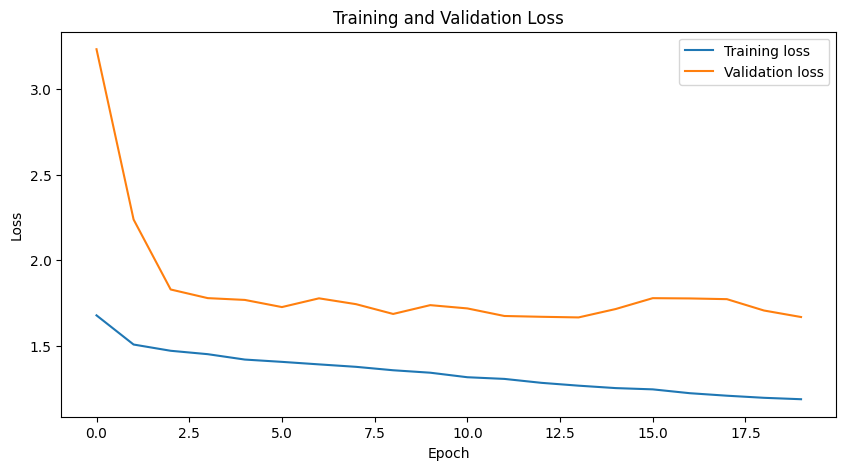

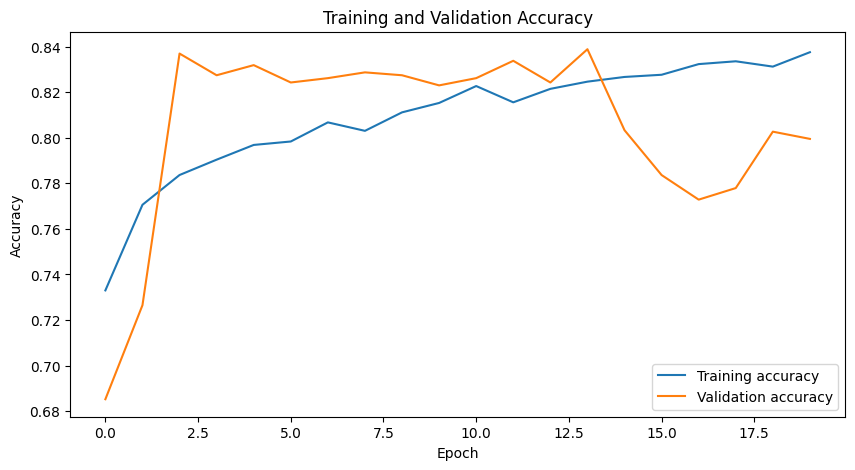

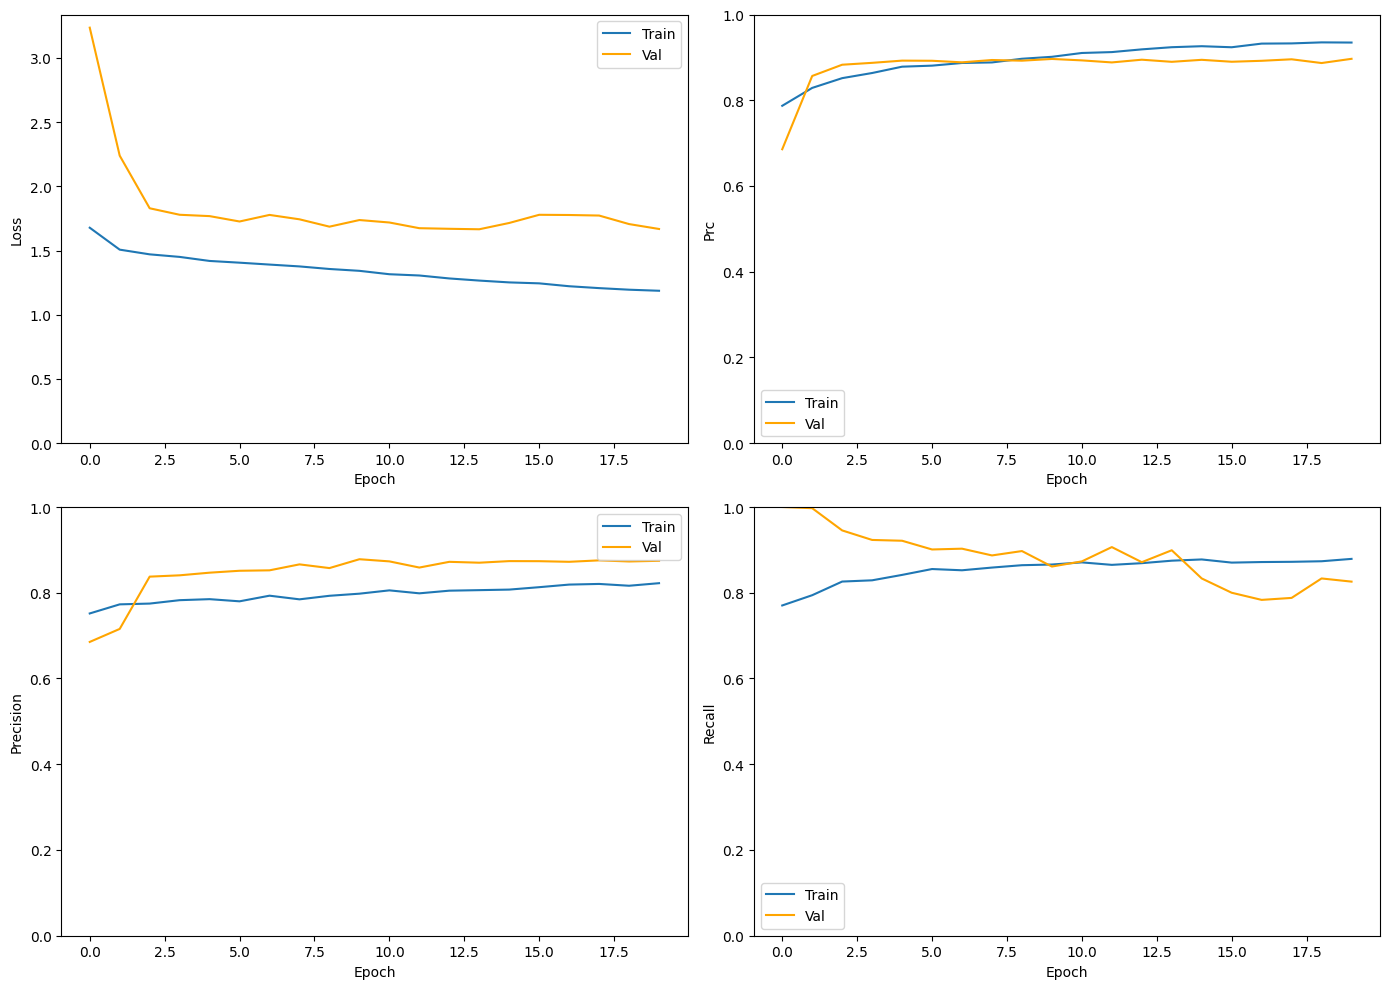

In [ ]:
all_info_about_training_model(history)

In [ ]:
model24=keras.saving.load_model('/content/zapisane/model605.keras')

25/25 [==============================] - 7s 279ms/step - loss: 1.3057 - tp: 499.0000 - fp: 24.0000 - tn: 223.0000 - fn: 49.0000 - accuracy: 0.9082 - precision: 0.9541 - recall: 0.9106 - auc: 0.9540 - prc: 0.9771
loss :  1.3057225942611694
tp :  499.0
fp :  24.0
tn :  223.0
fn :  49.0
accuracy :  0.9081761240959167
precision :  0.9541109204292297
recall :  0.9105839133262634
auc :  0.9539621472358704
prc :  0.9770743250846863
['benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'malignant'

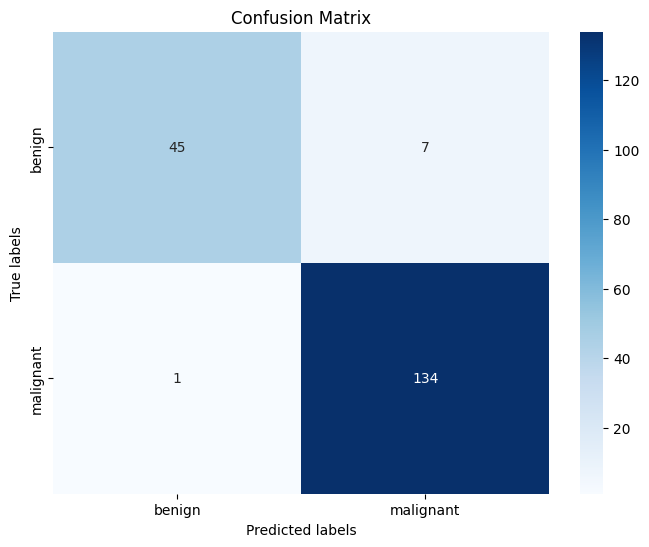

IsADirectoryError: [Errno 21] Is a directory: '/content/zapisane/testDataMagnificant/sto/benign/.ipynb_checkpoints'

In [ ]:
all_info_about_testing_model(model503)

In [ ]:
#@title sprawdzenie klasyfikacji przed trenowaniem ResNet
model2 = ResNet50(weights='imagenet')

# Ścieżka do obrazu
img_path = '/content/zapisane/breast/breast/benign/SOB_B_A-14-22549AB-100-001.png'

# Wczytaj obraz i przekształć go na tablicę
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Predykcja
preds = model2.predict(x)

# Dekodowanie wyników predykcji do listy krotek (klasa, opis, prawdopodobieństwo)
print('Predicted:', decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 1us/step
Predicted: [('n03485794', 'handkerchief', 0.8498303), ('n03938244', 'pillow', 0.06120114), ('n02869837', 'bonnet', 0.027716154)]


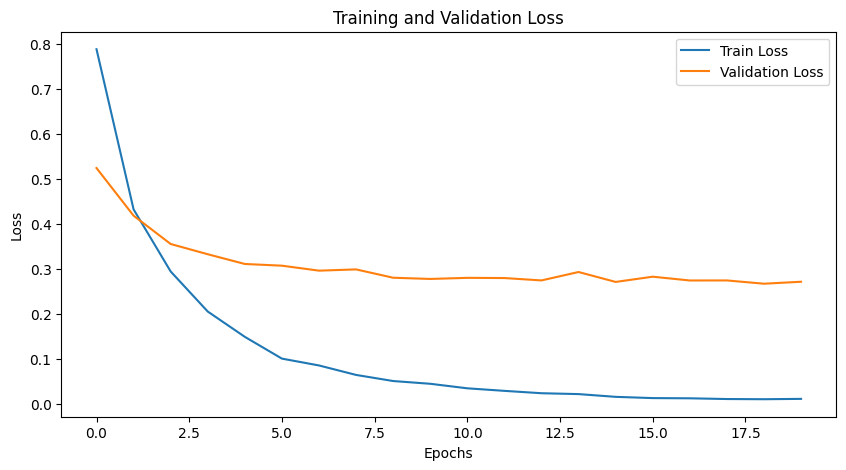

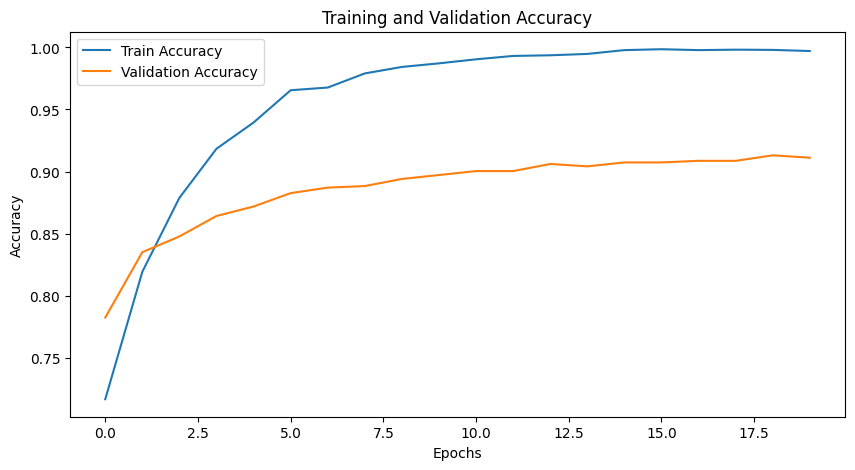

In [ ]:
#@title rysowanie wykresu dokładności i straty z zapisanej historii
history_path='/content/zapisane/history603.json'
with open(history_path,'r') as file:
  data=json.load(file)


#przeksztalcanie danych do list
train_loss = [value for key, value in data['loss'].items()]
train_accuracy = [value for key, value in data['accuracy'].items()]
val_loss = [value for key, value in data['val_loss'].items()]
val_accuracy = [value for key, value in data['val_accuracy'].items()]


#wykres loss i accuracy
epochs = range(len(train_loss))

# Wykres loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Wykres accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
#@title rysowanie ROC dla wielu modeli
# Funkcja do predykcji etykiet
test_data_dir3 = '/content/zapisane/breastAfterDivision2/test'

# Lista klas (nazwy folderów)
class_names = sorted(os.listdir(test_data_dir))

# Funkcja do predykcji etykiet
def predict_labels3(model, test_data_dir, class_names):
    y_true = []
    y_pred_prob = []

    for class_name in class_names:
        class_dir = os.path.join(test_data_dir, class_name)
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            if not img_file.endswith('.ipynb'):
                img = image.load_img(img_path, target_size=(224, 224))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)  # dodanie dodatkowego wymiaru wsadowego
                img_array /= 255.0  # normalizacja pikseli
                # Rzeczywista klasa obrazu
                y_true.append(0 if class_name == 'benign' else 1)
                # Predykcja modelu dla obrazu
                pred = model.predict(img_array, verbose=0)
                y_pred_prob.append(pred[0][0])

    return y_true, y_pred_prob

# Funkcja do rysowania krzywej ROC dla wielu modeli
def draw_ROC_multiple(models, model_names, test_data_dir, class_names):
    plt.figure()

    for model, name in zip(models, model_names):
        y_true, y_pred_prob = predict_labels3(model, test_data_dir, class_names)
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = %0.3f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Baseline')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()





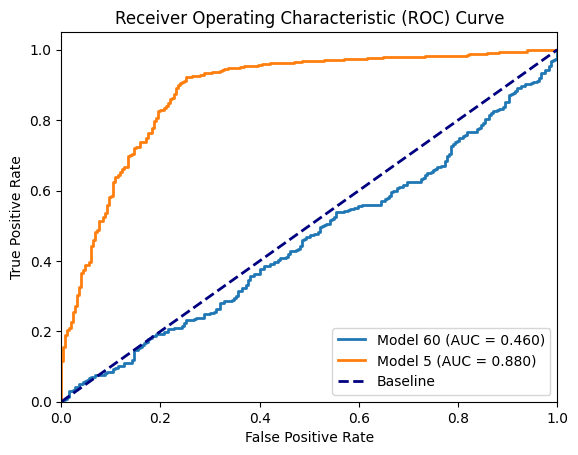

In [ ]:
model_paths = ['/content/zapisane/model60.keras', '/content/zapisane/model5.keras']
model_names = ['Model 60', 'Model 5']
models = [keras.saving.load_model(path) for path in model_paths]

draw_ROC_multiple(models, model_names, test_data_dir, class_names)